<a href="https://colab.research.google.com/github/hy30n80/KERC2022/blob/main/Model5-testsubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash



--2022-09-20 11:04:38--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-09-20 11:04:39--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce88bdbc8a89b0cab69535350d5.dl.dropboxusercontent.com/cd/0/get/BtRcA2BYYehvJgNVWJKOTN9Ei5KQXxtt0Uj9ro9YBE51cDcO1zMVfT5_drJm2fbjyJR6oNuw8ulugfeotDATBtlMGrKTg_mMIHCs8JVAVlZnCQY-Lpu4Qh7GianffLmx38a__8aj6heC_-n6B4MtGFxiMgOByF0RcKvg_TrnHDWF0qGxTuGE8Ptt_9l8oZ9XDWA/file?dl=1# [following]
--2022-09-20 11:04:39--  https://uce88bdbc8a89b0cab69535350d5.dl.dropboxusercontent.com/cd/0/get/BtRcA2BYYehv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from konlpy.tag import Okt, Mecab
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm
from tensorflow.keras.layers import(Input, Dense, Bidirectional, LSTM, Concatenate, concatenate, Embedding, Dropout)
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import sklearn

Mounted at /content/drive


In [38]:
!pip install wandb
!wandb login 5bcaa9827ad3815cd50d74dc7a2d2c6a80bd9e9a
import wandb
# !wandb login
    
wandb.init(project="kerc_wandb_test",
           config={
                  "layer_1_activation":"relu", 
                  "layer_1":128,
                   "learning_rate":0.01,
                   "dropout_rate": 0.2
            })

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


accuracy,▁▁▁▁▁▃▅▆▆▇███
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▇▇▆▅▅▄▃▃▂▂▁▁
lr,▁▁▁▁▂▂▂▃▄▄▅▆█
val_accuracy,▁▁▁▁▂▄▄▅▆▅▇▄█
val_loss,█▇▇▆▅▅▄▃▃▂▃▃▁
GFLOPs,0.0
accuracy,0.77199
best_epoch,12
best_val_loss,0.60957
epoch,12


In [8]:
train_x_path = './drive/MyDrive/KERC2022/KERC22Dataset_PublicTest/train_data.tsv'
train_y_path = './drive/MyDrive/KERC2022/KERC22Dataset_PublicTest/train_labels.csv'

In [9]:
EMBEDDING_DIM=100
MAXLEN = 30
TRUNCATING = 'post'
PADDING = 'pre'
OOV_TOKEN = '<OOV>'
NUM_WORDS = 15000
SPLIT_SIZE = 0.9

In [10]:
train_data = pd.read_csv(train_x_path, sep='\t')
labels = pd.read_csv(train_y_path)
#label csv 를 train_data에 병합
train_data['label'] = labels['label']
print(train_data[:5])
print(len(train_data))
print(train_data.isnull().sum())

   sentence_id person                                           sentence  \
0            1     어영  야! 전화 받아. 아무리 바빠도 내전화는 받아야 되는거 아냐? 약속 하나도 못지키는...   
1            2     어영     우리 아무래도 안되겠다. 이게 최선인거 같애. 평생 잊지 않을게. 행복하길 바란다.   
2            3    지구대                          김경사님, 아직 안가셨어요? 시간 다됐을텐데.   
3            4     순경                                         근무중인데 어딜가?   
4            5    지구대    다녀오세요. 이런날은 무조건 가서 축하해주셔야죠. 이순경이 대신 근무선다고 나온대요.   

   scene                                          context      label  
0  S0104                                              NaN  dysphoria  
1  S0108         포기한듯 탁 일어서는데, 띵동 문자. 후다닥 보는 어영. 기막혀 읽어보는  dysphoria  
2  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대    neutral  
3  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대  dysphoria  
4  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대   euphoria  
7339
sentence_id       0
person            0
sentence          0
scene             0
context        2017
label       

In [11]:
#context null 값 '결측' 으로 채우기
train_data['context'].fillna('결측', inplace=True)
print(train_data.isnull().sum())

sentence_id    0
person         0
sentence       0
scene          0
context        0
label          0
dtype: int64


In [12]:
# person, scene category 변형
train_data['person'].value_counts()
train_data['scene'].value_counts()


train_data['person'] = train_data['person'].astype('category')
train_data['scene'] = train_data['scene'].astype('category')


train_data['person']= train_data['person'].cat.codes
train_data['scene']= train_data['scene'].cat.codes
print(train_data[:5])

   sentence_id  person                                           sentence  \
0            1      42  야! 전화 받아. 아무리 바빠도 내전화는 받아야 되는거 아냐? 약속 하나도 못지키는...   
1            2      42     우리 아무래도 안되겠다. 이게 최선인거 같애. 평생 잊지 않을게. 행복하길 바란다.   
2            3      69                          김경사님, 아직 안가셨어요? 시간 다됐을텐데.   
3            4      36                                         근무중인데 어딜가?   
4            5      69    다녀오세요. 이런날은 무조건 가서 축하해주셔야죠. 이순경이 대신 근무선다고 나온대요.   

   scene                                          context      label  
0      0                                               결측  dysphoria  
1      1         포기한듯 탁 일어서는데, 띵동 문자. 후다닥 보는 어영. 기막혀 읽어보는  dysphoria  
2      2  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대    neutral  
3      2  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대  dysphoria  
4      2  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대   euphoria  


In [13]:
#전체 data 셔플

train_data=sklearn.utils.shuffle(train_data)
print(train_data)


      sentence_id  person                                  sentence  scene  \
1523         2525      31           주말에 웨딩드레스 보러 같이 가. 턱시도도 같이 맞추고.    191   
301           527       5                    맞다. 수상 아파트 3동 303호. 참,     42   
3621         6043      83  돈벌기가 쉬워? 당신 나가서 돈 벌어봐! 입에서 쓴내가 난다 쓴내가 나.    446   
881          1487      42                                        왜?    123   
6690        11214       1                 현찰아, 오늘만은 암말도 말아주라. 부탁한다.    813   
...           ...     ...                                       ...    ...   
3679         6147      72               그러게. 내가 열낼 필요없죠? 얼른 시작해 오빠.    457   
6984        11679      55                          여긴 경찰서보다 더 바쁘네요.    851   
7278        12180      36                              옷입고 잠깐 나와봐라.    896   
1857         3162      55                          우리 계급장 떼고 한판 붙자.    233   
3459         5800       5                                      내말이.    427   

                                                context      la

In [15]:
# Stopwords 는 우선 고려하지 않고 실행
# sentence , context 문자열 데이터로 처리



okt = Okt()
mecab = Mecab()

tok_sentences = []
for sen in tqdm(train_data['sentence']):
  tok_sen = mecab.morphs(sen)
  tok_sentences.append(tok_sen)

tok_contexts = []
for con in tqdm(train_data['context']):
  tok_con = mecab.morphs(con)
  tok_contexts.append(tok_con)

100%|██████████| 7339/7339 [00:01<00:00, 5601.68it/s]


[['주말', '에', '웨딩', '드레스', '보', '러', '같이', '가', '.', '턱시도', '도', '같이', '맞추', '고', '.'], ['맞', '다', '.', '수상', '아파트', '3', '동', '303', '호', '.', '참', ','], ['돈', '벌기', '가', '쉬워', '?', '당신', '나가', '서', '돈', '벌', '어', '봐', '!', '입', '에서', '쓴', '내', '가', '난다', '쓴', '내', '가', '나', '.'], ['왜', '?'], ['현찰', '아', ',', '오늘', '만', '은', '암말도', '말', '아', '주', '라', '.', '부탁', '한다', '.']]
문장 최대 길이:  81
문장 평균 길이:  15.150837988826815


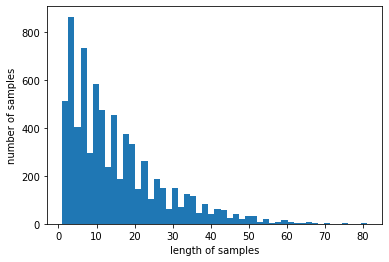

문맥 최대 길이:  19
문맥 평균 길이:  12.907344324839896


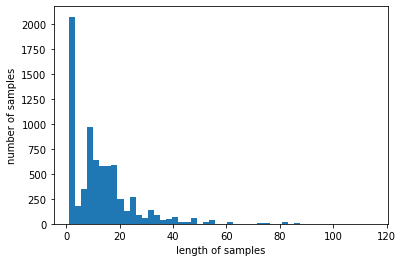

In [16]:
print(tok_sentences[:5])

print('문장 최대 길이: ', max(len(sen) for sen in tok_sentences))
print('문장 평균 길이: ', sum(map(len, tok_sentences))/len(tok_sentences))
plt.hist([len(sen) for sen in tok_sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

print('문맥 최대 길이: ', max(len(con) for sen in tok_contexts))
print('문맥 평균 길이: ', sum(map(len, tok_contexts))/len(tok_contexts))
plt.hist([len(con) for con in tok_contexts], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()



In [60]:
# sentence, context 을 통재로 묶어서 tokenize 만들고, 각각 적용
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize(train_sentences, train_contexts, oov_token):
  train_set = np.concatenate((train_sentences, train_contexts), axis=0)
  tokenizer = Tokenizer(oov_token = oov_token)
  tokenizer.fit_on_texts(train_set)
  return tokenizer

def fit_and_seq(train_sentences, train_contexts, maxlen, padding, truncating, tokenizer):
  sen_seq= tokenizer.texts_to_sequences(train_sentences)
  con_seq = tokenizer.texts_to_sequences(train_contexts)
  pad_sen_sequences= pad_sequences(sen_seq, maxlen=maxlen, padding=padding, truncating=truncating)
  pad_con_sequences= pad_sequences(con_seq, maxlen=maxlen, padding=padding, truncating=truncating)

  return pad_sen_sequences, pad_con_sequences

"""
def tokenize_label(labels):

  label_tokenizer = Tokenizer()
  label_tokenizer.fit_on_texts(labels)

  label_seq = label_tokenizer.texts_to_sequences(labels)
  label_seq_np = np.array(label_seq)-1

  return label_seq_np, label_tokenizer
"""


'\ndef tokenize_label(labels):\n\n  label_tokenizer = Tokenizer()\n  label_tokenizer.fit_on_texts(labels)\n\n  label_seq = label_tokenizer.texts_to_sequences(labels)\n  label_seq_np = np.array(label_seq)-1\n\n  return label_seq_np, label_tokenizer\n'

In [61]:
tokenizer = tokenize(tok_sentences, tok_contexts, OOV_TOKEN)
train_sentence_seq, train_context_seq = fit_and_seq(tok_sentences, tok_contexts, MAXLEN, PADDING, TRUNCATING, tokenizer)
word_index = tokenizer.word_index

print(train_sentence_seq.shape)
print(train_context_seq.shape)
print(train_sentence_seq[3])
print(train_context_seq[3])

print(word_index.items())

(20169, 30)
(20169, 30)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 69  5]
[   0    0    0    0    0    0    0    0    0    0    0    0   60    6
    3   31    2  129  185  351    4    2   18    4 1033 2503    3    2
   98    4]
dict_items([('<OOV>', 1), ('.', 2), ('는', 3), ('고', 4), ('?', 5), ('하', 6), ('이', 7), (',', 8), ('에', 9), ('가', 10), ('측', 11), ('결', 12), ('은', 13), ('도', 14), ('어', 15), ('들', 16), ('다', 17), ('보', 18), ('지', 19), ('이상', 20), ('게', 21), ('안', 22), ('해', 23), ('우미', 24), ('면', 25), ('거', 26), ('난', 27), ('앉', 28), ('있', 29), ('나', 30), ('어영', 31), ('들오', 32), ('을', 33), ('에서', 34), ('현찰', 35), ('건강', 36), ('청', 37), ('아', 38), ('말', 39), ('며', 40), ('한', 41), ('과자', 42), ('서', 43), ('는데', 44), ('순경', 45), ('오', 46), ('겠', 47), ('야', 48), ('없', 49), ('내', 50), ('먹', 51), ('사람', 52), ('나오', 53), ('뭐', 54), ('으로', 55), ('좋', 56), ('만', 57), ('니', 58), ('솔', 59), ('일', 60), ('알', 61), ('주', 62), ('좀', 63), ('했', 64), ('범인'

In [19]:
"""
#embedding matrix 압축해제
%cd /content/drive/MyDrive/KERC2022
!unzip -qq "/content/drive/MyDrive/KERC2022/word-embeddings.zip"
"""

/content/drive/MyDrive/KERC2022
replace word-embeddings/word2vec/word2vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [20]:
embedding_dict = dict()
f=open('/content/drive/MyDrive/KERC2022/word-embeddings/glove/glove.txt', encoding="utf8")

for line in f:
  word_vector = line.split()
  word = word_vector[0]

  word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
  embedding_dict[word]=word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' %len(embedding_dict))


358043개의 Embedding vector가 있습니다.


In [21]:
#100차원 embedding
print(len(embedding_dict['잘']))

100


In [22]:
embedding_matrix = np.zeros((NUM_WORDS, 100))
print(np.shape(embedding_matrix))


(15000, 100)


In [23]:
print(word_index.items())
print('단어 word index 가 4인 고에 대한 임베딩 벡터:', embedding_dict['고'])

dict_items([('<OOV>', 1), ('.', 2), ('는', 3), ('고', 4), ('하', 5), ('?', 6), (',', 7), ('이', 8), ('에', 9), ('가', 10), ('은', 11), ('측', 12), ('결', 13), ('어', 14), ('이상', 15), ('도', 16), ('보', 17), ('들', 18), ('다', 19), ('지', 20), ('어영', 21), ('우미', 22), ('게', 23), ('안', 24), ('거', 25), ('들오', 26), ('건강', 27), ('면', 28), ('난', 29), ('해', 30), ('있', 31), ('현찰', 32), ('며', 33), ('을', 34), ('나', 35), ('에서', 36), ('아', 37), ('청', 38), ('앉', 39), ('말', 40), ('한', 41), ('서', 42), ('나오', 43), ('으로', 44), ('야', 45), ('는데', 46), ('과자', 47), ('순경', 48), ('겠', 49), ('내', 50), ('먹', 51), ('사람', 52), ('범인', 53), ('뭐', 54), ('만', 55), ('없', 56), ('니', 57), ('오', 58), ('놓', 59), ('알', 60), ('좋', 61), ('일', 62), ('주', 63), ('좀', 64), ('재수', 65), ('했', 66), ('냐', 67), ('그', 68), ('자', 69), ('못', 70), ('로', 71), ('왜', 72), ('얼른', 73), ('님', 74), ('잘', 75), ('던', 76), ('되', 77), ('어요', 78), ('었', 79), ('너', 80), ('부영', 81), ('솔', 82), ('한테', 83), ('아니', 84), ('요', 85), ('아부지', 86), ('받', 87), ('할', 88), ('집

In [24]:
for word, index in tokenizer.word_index.items():
  vector_value = embedding_dict.get(word)
  if vector_value is not None:
    embedding_matrix[index]= vector_value

In [25]:
embedding_matrix[4]

array([-1.11049294e+00, -6.02223992e-01,  5.71654022e-01, -3.61927003e-01,
        7.45339990e-02, -7.51710013e-02, -9.82264996e-01, -3.60437989e-01,
       -1.58338594e+00, -8.54599997e-02, -1.71569996e-02,  1.11514902e+00,
       -5.17001987e-01, -7.87141025e-01, -8.30124974e-01,  4.60023999e-01,
        7.49590024e-02,  3.69709991e-02,  6.60499977e-03,  1.49837002e-01,
        2.37296009e+00,  2.93150008e-01,  2.54455000e-01, -8.94550011e-02,
        3.52138996e-01, -1.35179996e-01,  2.52279013e-01,  4.24050018e-02,
       -8.60870034e-02,  3.39881986e-01, -1.65535003e-01, -5.74100018e-03,
       -1.34199997e-03,  5.74189983e-02,  3.51019986e-02, -4.19905990e-01,
        2.02687994e-01,  6.51202977e-01,  8.13265979e-01,  3.16426009e-01,
       -5.41135013e-01, -3.91431004e-01, -1.28048003e-01,  2.03174993e-01,
        5.35090983e-01,  1.14778197e+00, -4.43010986e-01, -1.27355897e+00,
        1.38452601e+00,  4.50946003e-01, -9.98980030e-02,  1.03630997e-01,
        5.87269999e-02, -

In [26]:
#label 값 0,1,2 로 Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le = le.fit(train_data['label'])

train_label_seq = le.transform(train_data['label'])
print(le.classes_)
print(train_data['label'][:10])
print(train_label_seq[:10])

#dysphoria:0, euphoria:1, neutral:2

['dysphoria' 'euphoria' 'neutral']
1523     euphoria
301       neutral
3621    dysphoria
881       neutral
6690    dysphoria
3884    dysphoria
6972     euphoria
5879     euphoria
6515     euphoria
1308    dysphoria
Name: label, dtype: object
[1 2 0 2 0 0 1 1 1 0]


In [27]:
"""
def train_val_split(sentences, labels, training_split):

  train_size = int(len(sentences)*training_split)

  train_sentences = sentences[:train_size]
  train_labels = labels[:train_size]


  val_sentences = sentences[train_size:]
  val_labels = labels[train_size:]

  return train_sentences, train_labels, val_sentences, val_labels
"""

'\ndef train_val_split(sentences, labels, training_split):\n\n  train_size = int(len(sentences)*training_split)\n\n  train_sentences = sentences[:train_size]\n  train_labels = labels[:train_size]\n\n\n  val_sentences = sentences[train_size:]\n  val_labels = labels[train_size:]\n\n  return train_sentences, train_labels, val_sentences, val_labels\n'

In [28]:
print(type(np.array(train_data['person'])), type(train_sentence_seq),type(train_context_seq), type(train_data['scene']) )

print(np.array(train_data['person']).shape)
print(train_sentence_seq.shape)
print(np.array(train_data['person']))
print(train_sentence_seq)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
(7339,)
(7339, 30)
[31  5 83 ... 36 55  5]
[[   0    0    0 ... 1299    4    2]
 [   0    0    0 ...    2  378    7]
 [   0    0    0 ...   10   35    2]
 ...
 [   0    0    0 ...  693  558    2]
 [   0    0    0 ... 1748   69    2]
 [   0    0    0 ...    0 1974    2]]


In [29]:
#Data split 
from sklearn.model_selection import train_test_split
train_sentences, test_sentences = train_test_split(train_sentence_seq, test_size=0.1, shuffle=False)
train_contexts, test_contexts = train_test_split(train_context_seq, test_size=0.1, shuffle=False)
train_people, test_people = train_test_split(np.array(train_data['person']), test_size=0.1, shuffle=False)
train_scenes, test_scenes = train_test_split(np.array(train_data['scene']), test_size=0.1, shuffle=False)
train_labels, test_labels = train_test_split(train_label_seq, test_size=0.1, shuffle=False)

In [30]:

print(train_sentences.shape)
print(train_contexts.shape)
print(train_people.shape)
print(train_scenes.shape)
print(train_labels.shape)

print(test_sentences.shape)
print(test_contexts.shape)
print(test_people.shape)
print(test_scenes.shape)
print(test_labels.shape)



(6605, 30)
(6605, 30)
(6605,)
(6605,)
(6605,)
(734, 30)
(734, 30)
(734,)
(734,)
(734,)


In [41]:
def create_model(num_words, embedding_dim, maxlen):
  

  input_P = Input(shape=[1], name = "input_person")
  input_S = Input(shape=[1], name = "input_scene")
  input_sen = Input(shape=[30], name = "input_sentence")
  input_con = Input(shape=[30], name = "input_context")

  Dense_p1 = Dense(8, activation = 'relu')(input_P)
  Dense_p2 = Dense(4, activation = 'sigmoid')(Dense_p1)

  Dense_s1 = Dense(8, activation = 'relu')(input_S)
  Dense_s2 = Dense(1, activation = 'sigmoid')(Dense_s1)

  Embedding1 = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input_sen)
  LSTM_sen = Bidirectional(LSTM(16, return_sequences=False))(Embedding1)
  Dense_sen = Dense(16, activation = 'sigmoid')(LSTM_sen)

  Embedding2 = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input_con)
  LSTM_con = Bidirectional(LSTM(16, return_sequences=False))(Embedding2)
  Dense_con = Dense(16, activation = 'sigmoid')(LSTM_con)

  
  concat = concatenate([Dense_p2, Dense_s2, Dense_sen, Dense_con], name='concat')
  Drp1 = Dropout(0.3)(concat)
  Dense1 = Dense(16, activation = 'relu')(concat)
  Dense2 = Dense(8, activation = 'relu')(Dense1)
  Drp = Dropout(0.2)(Dense2)
  output = Dense(3, activation = 'softmax')(Dense2)


  model = tf.keras.Model(inputs =[input_P, input_S, input_sen, input_con], outputs=[output])


  return model


In [42]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentence (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 input_context (InputLayer)     [(None, 30)]         0           []                               
                                                                                                  
 input_person (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 input_scene (InputLayer)       [(None, 1)]          0           []                               
                                                                                              

In [44]:
"""
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4*10**(epoch/10))
"""
optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-4)


In [45]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
from wandb.keras import WandbCallback

In [47]:
history = model.fit((train_people, train_scenes, train_sentences, train_contexts), train_labels, epochs=30, 
                    validation_data = ((test_people, test_scenes, test_sentences, test_contexts), test_labels), callbacks=[ WandbCallback()])

Epoch 1/30
207/207 [==============================] - 21s 51ms/step - loss: 0.9336 - accuracy: 0.5731 - val_loss: 0.8748 - val_accuracy: 0.6308
Epoch 2/30
207/207 [==============================] - 8s 41ms/step - loss: 0.8749 - accuracy: 0.6151 - val_loss: 0.8390 - val_accuracy: 0.6308
Epoch 3/30
207/207 [==============================] - 8s 41ms/step - loss: 0.8439 - accuracy: 0.6182 - val_loss: 0.8131 - val_accuracy: 0.6431
Epoch 4/30
207/207 [==============================] - 9s 41ms/step - loss: 0.8064 - accuracy: 0.6410 - val_loss: 0.7928 - val_accuracy: 0.6649
Epoch 5/30
207/207 [==============================] - 11s 55ms/step - loss: 0.7762 - accuracy: 0.6612 - val_loss: 0.7729 - val_accuracy: 0.6662
Epoch 6/30
207/207 [==============================] - 9s 41ms/step - loss: 0.7464 - accuracy: 0.6771 - val_loss: 0.7684 - val_accuracy: 0.6717
Epoch 7/30
207/207 [==============================] - 9s 41ms/step - loss: 0.7244 - accuracy: 0.6898 - val_loss: 0.7428 - val_accuracy: 0.67

wandb: Adding directory to artifact (/content/wandb/run-20220920_112054-14oravkz/files/model-best)... Done. 0.2s


207/207 [==============================] - 61s 294ms/step - loss: 0.5376 - accuracy: 0.7805 - val_loss: 0.5910 - val_accuracy: 0.7766
Epoch 18/30
206/207 [============================>.] - ETA: 0s - loss: 0.5223 - accuracy: 0.7814

wandb: Adding directory to artifact (/content/wandb/run-20220920_112054-14oravkz/files/model-best)... Done. 0.2s


207/207 [==============================] - 44s 215ms/step - loss: 0.5223 - accuracy: 0.7814 - val_loss: 0.5882 - val_accuracy: 0.7643
Epoch 19/30
207/207 [==============================] - 9s 43ms/step - loss: 0.5119 - accuracy: 0.7902 - val_loss: 0.5930 - val_accuracy: 0.7589
Epoch 20/30
207/207 [==============================] - 9s 41ms/step - loss: 0.5061 - accuracy: 0.7900 - val_loss: 0.6074 - val_accuracy: 0.7425
Epoch 21/30
207/207 [==============================] - 9s 42ms/step - loss: 0.4941 - accuracy: 0.7935 - val_loss: 0.5959 - val_accuracy: 0.7711
Epoch 22/30
207/207 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.7995

wandb: Adding directory to artifact (/content/wandb/run-20220920_112054-14oravkz/files/model-best)... Done. 0.2s


207/207 [==============================] - 46s 223ms/step - loss: 0.4829 - accuracy: 0.7995 - val_loss: 0.5835 - val_accuracy: 0.7684
Epoch 23/30
207/207 [==============================] - 9s 44ms/step - loss: 0.4771 - accuracy: 0.8062 - val_loss: 0.5943 - val_accuracy: 0.7480
Epoch 24/30
207/207 [==============================] - 9s 42ms/step - loss: 0.4652 - accuracy: 0.8103 - val_loss: 0.6021 - val_accuracy: 0.7548
Epoch 25/30
207/207 [==============================] - 9s 41ms/step - loss: 0.4536 - accuracy: 0.8144 - val_loss: 0.6177 - val_accuracy: 0.7411
Epoch 26/30
207/207 [==============================] - 9s 42ms/step - loss: 0.4480 - accuracy: 0.8144 - val_loss: 0.6111 - val_accuracy: 0.7425
Epoch 27/30
207/207 [==============================] - 9s 42ms/step - loss: 0.4392 - accuracy: 0.8254 - val_loss: 0.6229 - val_accuracy: 0.7398
Epoch 28/30
207/207 [==============================] - 9s 42ms/step - loss: 0.4361 - accuracy: 0.8238 - val_loss: 0.6240 - val_accuracy: 0.7480
Ep

In [67]:
public_test_path = '/content/drive/MyDrive/KERC2022/KERC22Dataset_PublicTest/public_test_data.tsv'
public_test_data = pd.read_csv(public_test_path, sep='\t')

public_test_data['context'].fillna('결측', inplace=True)
print(train_data.isnull().sum())

public_test_data['person'].value_counts()
public_test_data['scene'].value_counts()


public_test_data['person'] = public_test_data['person'].astype('category')
public_test_data['scene'] = public_test_data['scene'].astype('category')


public_test_data['person']= public_test_data['person'].cat.codes
public_test_data['scene']= public_test_data['scene'].cat.codes


tok_test_sentences = []
for test_sen in tqdm(public_test_data['sentence']):
  tok_sen = mecab.morphs(test_sen)
  tok_test_sentences.append(tok_sen)

tok_test_contexts = []
for test_con in tqdm(public_test_data['context']):
  tok_con = mecab.morphs(test_con)
  tok_test_contexts.append(tok_con)

test_sentence, test_context = fit_and_seq(tok_test_sentences, tok_test_contexts, MAXLEN, PADDING, TRUNCATING, tokenizer)

test_people = np.array(public_test_data['person'])
test_scenes = np.array(public_test_data['scene'])

print(test_people.shape, test_scenes.shape, test_sentence.shape, test_context.shape)


sentence_id    0
person         0
sentence       0
scene          0
context        0
label          0
dtype: int64


100%|██████████| 2566/2566 [00:00<00:00, 6982.42it/s]


(2566,) (2566,) (2566, 30) (2566, 30)


In [81]:
result = model.predict((test_people, test_scenes, test_sentence, test_context))
predict = tf.argmax(result, axis=1)
predict = np.array(predict)
print(predict)
print(len(predict))

predict_s = []
for i in range(len(predict)):
  if predict[i]==0:
    predict_s.append('dysphoria')
  elif predict[i]==1:
    predict_s.append('euphoria')
  else:
    predict_s.append('neutral')
print(predict_s)
print(len(predict_s))

[0 0 0 ... 2 0 2]
2566
['dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'neutral', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'neutral', 'dysphoria', 'dysphoria', 'euphoria', 'euphoria', 'euphoria', 'neutral', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'euphoria', 'dysphoria', 'dysphoria', 'euphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'euphoria', 'neutral', 'neutral', 'neutral', 'dysphoria', 'neutral', 'dysphoria', 'neutral', 'neutral', 'dysphoria', 'dysphoria', 'dysphoria', 'neutral', 'neutral', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'neutral', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'dysphoria', 'neutral', 'dysphoria', 'neutral', 'neutral', 'euphoria', 'dysphoria', 'euphoria', 'euphoria', 'neutral', 'neutral', 'euph

In [80]:
import csv
with open("result.csv",'w') as file:
  writer = csv.writer(file)
  for i in range(len(predict_s)):
    writer.writerow([predict_s[i]])